In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
sys.path.append("../")

In [3]:
from Transformers import UNetDataset, ChannelsFirst, ToTensor, Rescale

In [4]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT
train_test = os.path.join(data_dir, "train_validation_test")

In [5]:
data = np.load("/storage/yw18581/data/train_validation_test/Xy_train+val_clean_300_24_10_25.npz")
x = data["x"]
y = data['y']
dist = np.unique(data['dist'], return_inverse=True)[1]

In [6]:
composed = transforms.Compose([Rescale(.25), ChannelsFirst(), ToTensor()])

In [7]:
train_dataset = UNetDataset(x, y, transform=composed, dist = dist)

In [8]:
data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

In [9]:
torch.cuda.empty_cache() 

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [12]:
model = cUNet()

In [13]:
criterion_mask = dice_loss

In [14]:
criterion_class = nn.CrossEntropyLoss()

In [15]:
model.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [16]:
import torch.optim as optim


optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [100]:
epochs = 20

In [17]:
for epoch in range(epochs):
    print("Epoch {}\n".format(epoch+1))
    running_loss = 0.0
    for i, batch in enumerate(data_loader):
        inputs = batch['image'].float().to(device)
        labels_mask = batch['mask'].float().to(device)
        labels_dist = batch['dist'].long().to(device)
        #print(inputs.is_cuda, labels_mask.is_cuda, labels_dist.is_cuda)
        optimizer.zero_grad()
        out_mask, out_class  = model(inputs)
        #print(out_mask.is_cuda)
        #print(out_class.is_cuda)
        loss_mask = criterion_mask(out_mask, labels_mask)
        loss_class = criterion_class(out_class, labels_dist)
        loss = loss_mask + loss_class
        #print(loss_mask, loss_class)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 60 == 59:    # print every 2000 mini_batches
            print('[%d, %5d] loss: %.3f' % 
                 (epoch + 1, i + 1, running_loss / 60))
print('Finished Training')

Epoch 1

[1,    30] loss: 1.358
[1,    60] loss: 2.717
Epoch 2

[2,    30] loss: 1.358
[2,    60] loss: 2.717
Epoch 3

[3,    30] loss: 1.358
[3,    60] loss: 2.716
Epoch 4

[4,    30] loss: 1.359
[4,    60] loss: 2.716
Epoch 5

[5,    30] loss: 1.357
[5,    60] loss: 2.716
Epoch 6

[6,    30] loss: 1.357
[6,    60] loss: 2.715
Epoch 7

[7,    30] loss: 1.357
[7,    60] loss: 2.716
Epoch 8

[8,    30] loss: 1.357
[8,    60] loss: 2.715
Epoch 9

[9,    30] loss: 1.358
[9,    60] loss: 2.715
Epoch 10

[10,    30] loss: 1.358
[10,    60] loss: 2.714
Epoch 11

[11,    30] loss: 1.357
[11,    60] loss: 2.714
Epoch 12

[12,    30] loss: 1.356
[12,    60] loss: 2.712
Epoch 13

[13,    30] loss: 1.355
[13,    60] loss: 2.700
Epoch 14

[14,    30] loss: 1.284
[14,    60] loss: 2.253
Epoch 15

[15,    30] loss: 0.583
[15,    60] loss: 1.016
Epoch 16

[16,    30] loss: 0.303
[16,    60] loss: 0.499
Epoch 17

[17,    30] loss: 0.023
[17,    60] loss: -0.033
Epoch 18

[18,    30] loss: -0.158
[18, 

In [25]:
torch.save(model.state_dict(), "../model/trained_cUNet_pytorch_{}epochs.pkl".format(epochs))

In [26]:
model_inference = cUNet()

In [27]:
model_inference.load_state_dict(torch.load("../model/trained_cUNet_pytorch_{}epochs.pkl".format(epochs)))

<All keys matched successfully>

In [101]:
test_data = np.load("/storage/yw18581/data/train_validation_test/Xy_test_clean_300_24_10_25.npz")
x_test = test_data["x"]
y_test = test_data['y']
dist_test = test_data['dist']
dist_test_idx = np.unique(dist_test, return_inverse=True)[1]

In [104]:
test_dataset = UNetDataset(x_test, y_test, transform=composed, dist = dist_test_idx)

test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

In [68]:
model_inference = model.eval()

In [69]:
model_inference.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [70]:
import matplotlib.pyplot as plt

In [102]:
dist_dict = {str(idx):cl  for (cl, idx) in 
             zip(np.unique(dist_test), np.unique(dist_test_idx))}

batch 1
1: true_dist: 25, pred_dist: 25


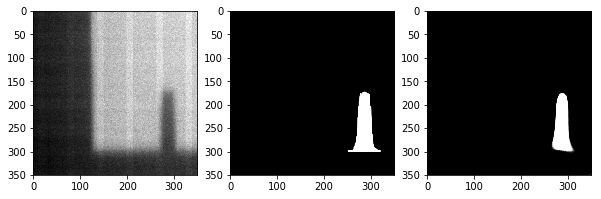

2: true_dist: 10, pred_dist: 10


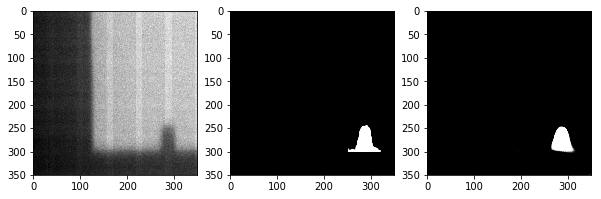

3: true_dist: 2, pred_dist: 2


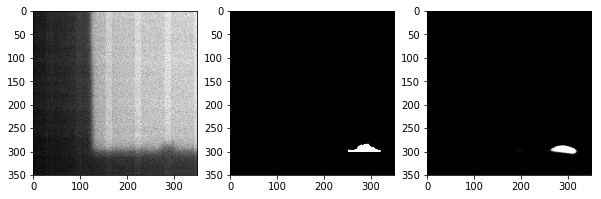

4: true_dist: 2, pred_dist: 2


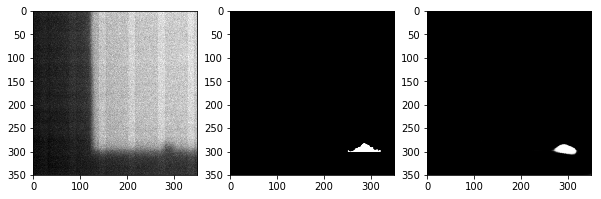

5: true_dist: 25, pred_dist: 25


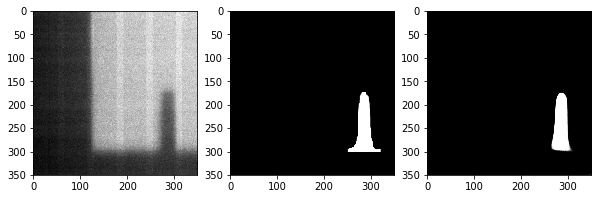

6: true_dist: 4, pred_dist: 4


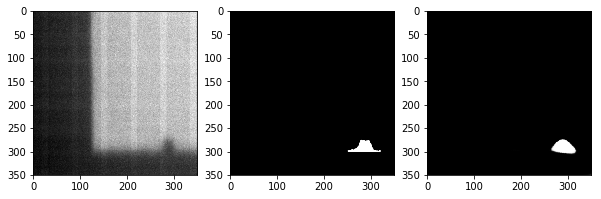

7: true_dist: 2, pred_dist: 2


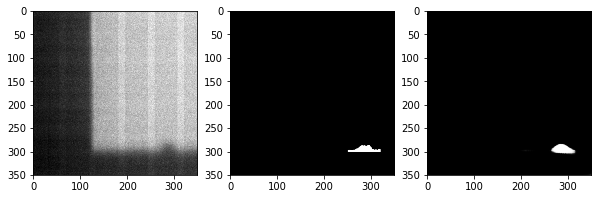

8: true_dist: 25, pred_dist: 25


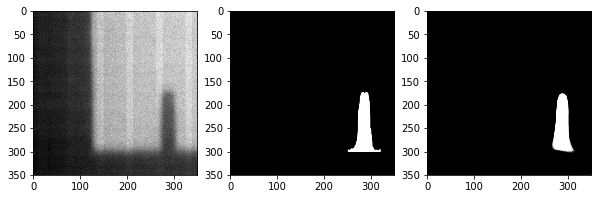

9: true_dist: 4, pred_dist: 4


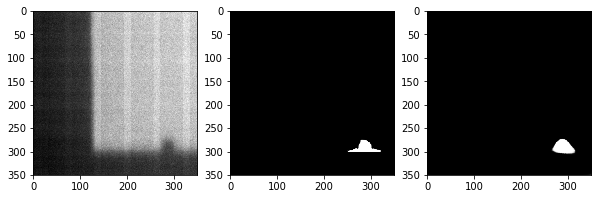

10: true_dist: 10, pred_dist: 10


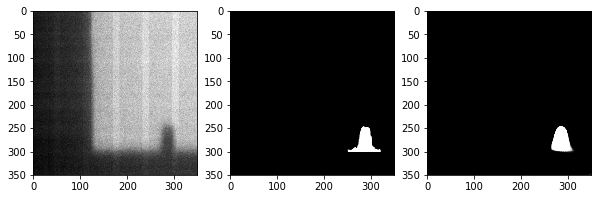

11: true_dist: 10, pred_dist: 10


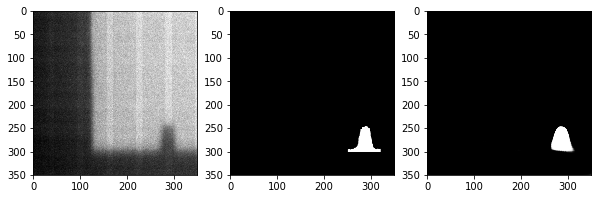

12: true_dist: 4, pred_dist: 4


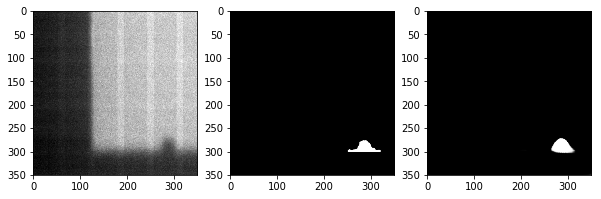

13: true_dist: 4, pred_dist: 4


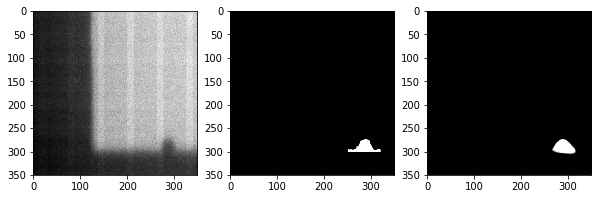

14: true_dist: 4, pred_dist: 4


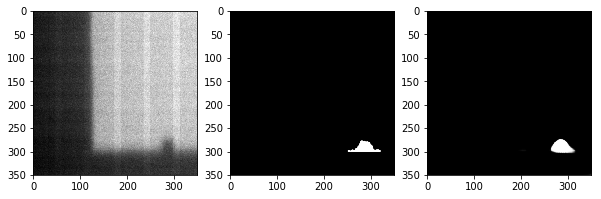

15: true_dist: 25, pred_dist: 25


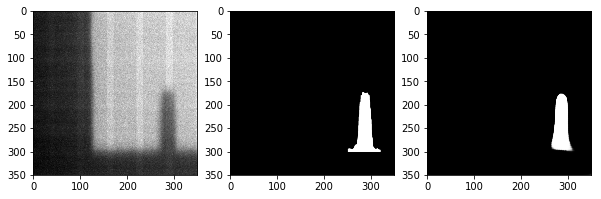

16: true_dist: 2, pred_dist: 2


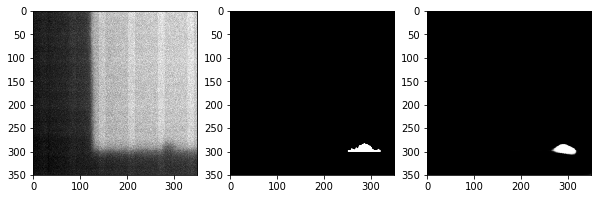

batch 2
1: true_dist: 4, pred_dist: 4


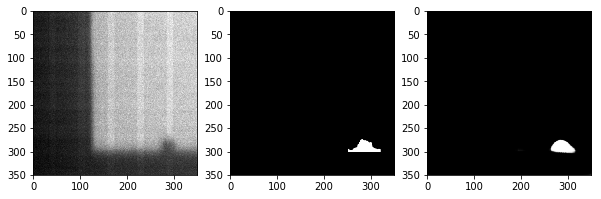

2: true_dist: 2, pred_dist: 2


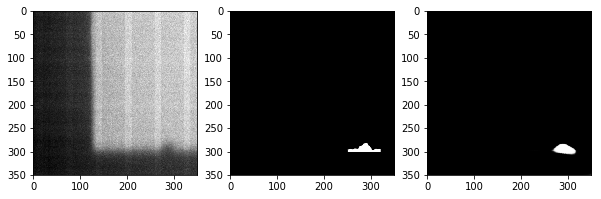

3: true_dist: 4, pred_dist: 4


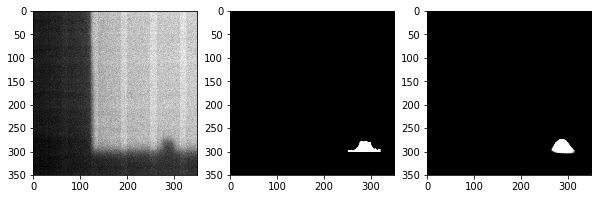

4: true_dist: 2, pred_dist: 2


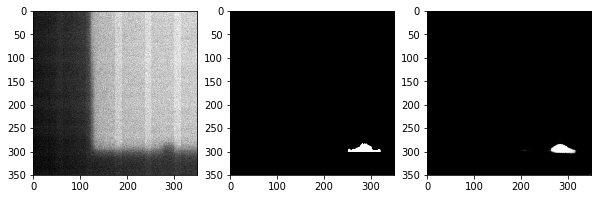

5: true_dist: 4, pred_dist: 4


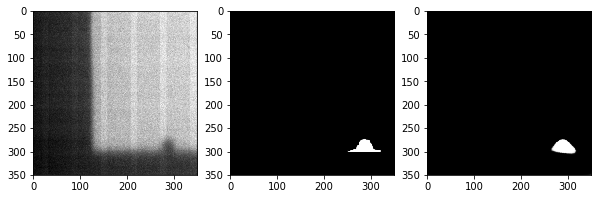

6: true_dist: 4, pred_dist: 4


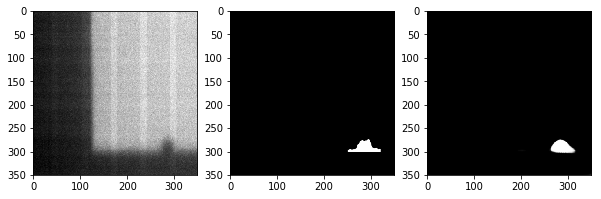

7: true_dist: 10, pred_dist: 10


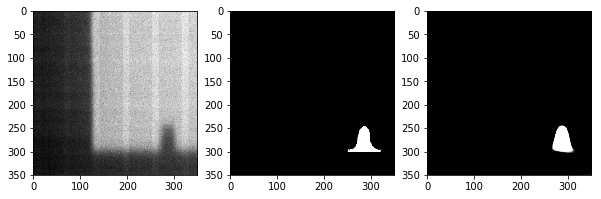

8: true_dist: 25, pred_dist: 25


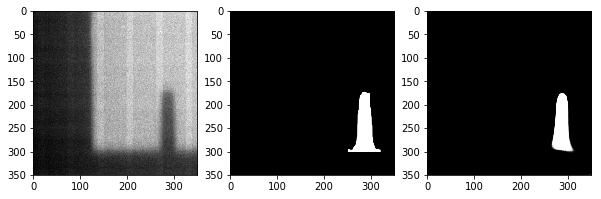

9: true_dist: 10, pred_dist: 10


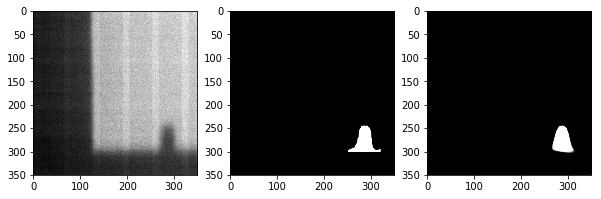

10: true_dist: 2, pred_dist: 2


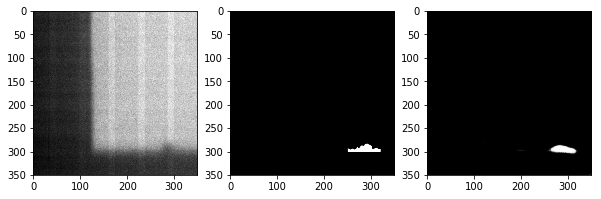

11: true_dist: 10, pred_dist: 10


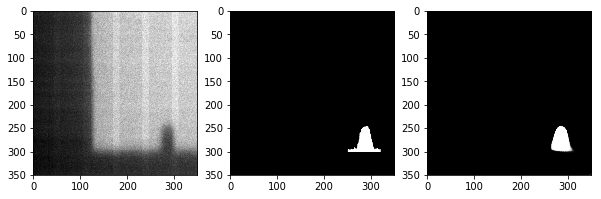

12: true_dist: 10, pred_dist: 10


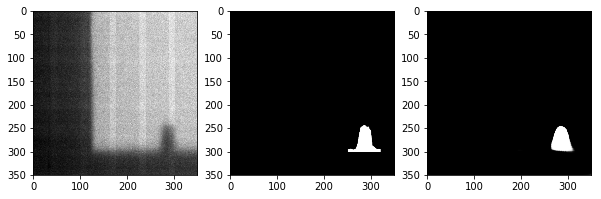

13: true_dist: 2, pred_dist: 2


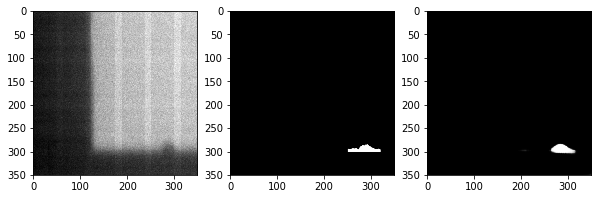

14: true_dist: 25, pred_dist: 25


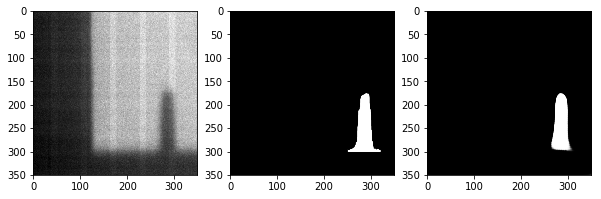

15: true_dist: 25, pred_dist: 25


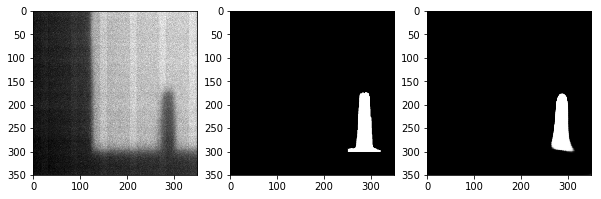

16: true_dist: 25, pred_dist: 25


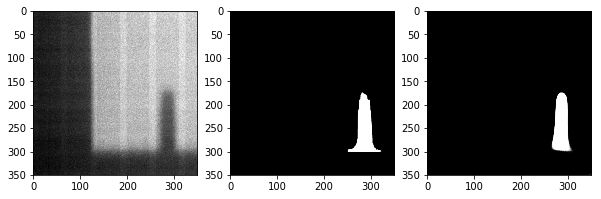

In [105]:
for i, batch in enumerate(test_data_loader):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_cl, pr_msk, pr_cl) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = dist_dict[str(tr_cl)]
        pred_dist = dist_dict[str(np.argmax(pr_cl))]
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [106]:
y_test = []
y_pred = []
for i, batch in enumerate(test_data_loader):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_cl, pr_cl) in enumerate(zip(true_images,
                                                 true_dists.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = dist_dict[str(tr_cl)]
        pred_dist = dist_dict[str(np.argmax(pr_cl))]
        y_test.append(true_dist)
        y_pred.append(pred_dist)

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15


In [107]:
15*16

240

In [108]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [109]:
confusion_matrix(y_test, y_pred)

array([[60,  0,  0,  0],
       [ 0, 60,  0,  0],
       [ 0,  0, 60,  0],
       [ 0,  0,  0, 60]])

In [110]:
accuracy_score(y_test, y_pred)

1.0